## Section 4.2 Polynomials augmented with weighted polynomials

In [1]:
using Pkg
Pkg.activate("../")
Pkg.instantiate()

  Activating project at `~/Documents/julia/gitpackages/EnrichedAZalgorithm`


In [2]:
using BasisFunctions, BenchmarkTools, AZalgorithm, Plots, BlockArrays, LinearMaps, ColorSchemes, StaticArrays, LinearAlgebra
BenchmarkTools.DEFAULT_PARAMETERS.samples=8
using BasisFunctions: ⊕     # clash with LinearMaps
using GridArrays: ×
include("../util/modgreen_defs.jl") 

lhelmfs (generic function with 5 methods)

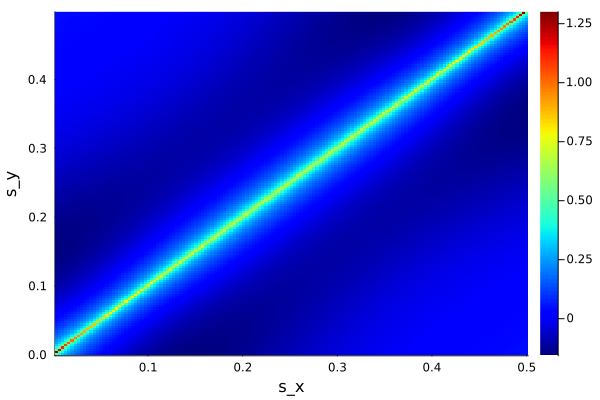

In [3]:
# function to be approximated
greensfunction(x, y, E) = lhelmfs(x[1]+im*x[2], y[1]+im*y[2], E)
gamma = t -> [cos(2*pi*t); sin(2*pi*t)]
fun = x -> real(greensfunction(gamma(x[1]), gamma(x[2]), 5.0))           
w = (x1,x2) -> log(1/sqrt((gamma(x1)[1] - gamma(x2)[1])^2 + (gamma(x1)[2] - gamma(x2)[2])^2))                              
D = 0..0.5
xx = EquispacedGrid(150,D)[2:end]
yy =  UnitPeriodicEquispacedGrid(150) → D   # we don't want to evaluate the function at x = y
heatmap(xx,yy,fun.(yy × xx), xlabel="s_x", ylabel="s_y", c=:jet1)

### Section 4.2.1 Approximation using an oversampled Chebyshev grid

In [4]:
# approximate fun using N Chebsyhev polynomials and K weighted Chebyshev polynomials on an oversampled Chebyshev grid (M_N = 4N, M_K = 0)
# using the AZ algorithm for enriched bases
function weightedchebyshev_az1(sqrtN, sqrtK, w, fun; timing=false, D=0..0.5)
    approxset = (ChebyshevT(sqrtN)→D)^2 ⊕ (w * ((ChebyshevT(sqrtK)→D)^2))
    basis = component(approxset,1)
    enriched = component(approxset,2)

    samples = (ChebyshevNodes(2sqrtN)→D) × (ChebyshevExtremae(2sqrtN)→D)                    
    Z11op = BasisFunctions.leastsquares(basis, samples)
    A11op = evaluation(basis,samples)
    A12op = evaluation(enriched, samples)
    Z11 = FunctionMap{coefficienttype(approxset)}(t -> (Z11op*t)[:], sqrtN^2, length(samples))
    A11 = FunctionMap{coefficienttype(approxset)}(t -> (A11op*t)[:], length(samples), sqrtN^2)
    A12 = FunctionMap{coefficienttype(approxset)}(t -> (A12op*t)[:], length(samples), sqrtK^2)
    rhs = fun.(samples[:])
    
    t = timing ? median(@benchmark(enrichedaz($A11, $A12, $Z11, $rhs))).time*1e-9 : 0. # time in seconds

    if (~timing)
        coeff = enrichedaz(A11, A12, Z11, fun.(samples[:]))
        approx = Expansion(approxset, BlockArray(coeff, [sqrtN^2,sqrtK^2] ))
        xx = EquispacedGrid(150,D)[2:end] × (UnitPeriodicEquispacedGrid(150) → D)   
        m = norm(fun.(xx) - approx.(xx), 2)/sqrt(length(xx[:]))                     # L^2 norm
    else
        m = 0.
        approx = Expansion(approxset, zeros(approxset))
    end

    m, approx, t
end

weightedchebyshev_az1 (generic function with 1 method)

In [5]:
# approximate fun using N Chebsyhev polynomials on an oversampled Chebyshev grid (M_N = 4N, M_K = 0)
function chebyshev(sqrtN, fun; timing=false, D=0..0.5)
    basis = (ChebyshevT(sqrtN)→D)^2
    samples = (ChebyshevNodes(2sqrtN)→D) × (ChebyshevExtremae(2sqrtN)→D)                    
    A = BasisFunctions.leastsquares(basis,samples)
    rhs = fun.(samples)

    t = timing ? median(@benchmark($A*$rhs)).time*1e-9 : 0.              # time in seconds

    if (~timing)
        coeff = A*fun.(samples)
        approx = Expansion(basis, coeff)
        xx = EquispacedGrid(150,D)[2:end] × (UnitPeriodicEquispacedGrid(150) → D)   
        m = norm(fun.(xx) - approx.(xx), 2)/sqrt(length(xx[:]))                     # L^2 norm
    else
        m = 0.
        approx = Expansion(basis, zeros(basis))
    end

    m, approx, t
end

chebyshev (generic function with 1 method)

┌ Warning: Reshaping input of tensor product operator from vector to tensor
└ @ BasisFunctions /Users/astridherremans/.julia/packages/BasisFunctions/3Z4cI/src/operator/tensorproductoperator.jl:91
┌ Warning: Reshaping input of tensor product operator from vector to tensor
└ @ BasisFunctions /Users/astridherremans/.julia/packages/BasisFunctions/3Z4cI/src/operator/tensorproductoperator.jl:91


┌ Warning: Reshaping input of tensor product operator from vector to tensor
└ @ BasisFunctions /Users/astridherremans/.julia/packages/BasisFunctions/3Z4cI/src/operator/tensorproductoperator.jl:91
┌ Warning: Reshaping input of tensor product operator from vector to tensor
└ @ BasisFunctions /Users/astridherremans/.julia/packages/BasisFunctions/3Z4cI/src/operator/tensorproductoperator.jl:91


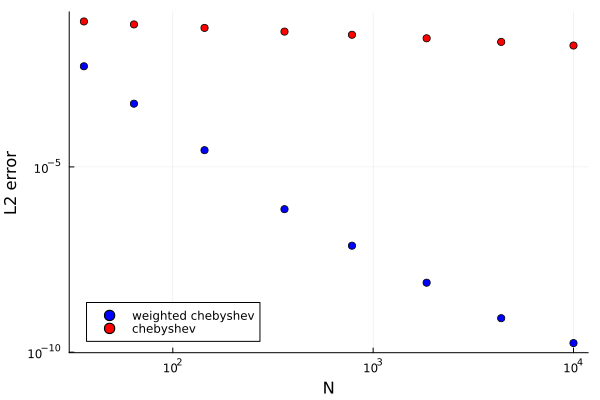

In [6]:
# plot of the accuracy (this takes about 2min15sec)
Nlist = ceil.(Int,sqrt.(10 .^range(log10(5^2),log10(100^2),8)))
scatter(Nlist.^2, [x[1] for x in weightedchebyshev_az1.(Nlist, 5, w, fun)], yscale=:log10, xscale=:log10, label="weighted chebyshev", legend=:bottomleft, markercolor=:blue, xlabel="N", ylabel="L2 error")
scatter!(Nlist.^2, [x[1] for x in chebyshev.(Nlist, fun)], yscale=:log10, label="chebyshev", markercolor=:red)

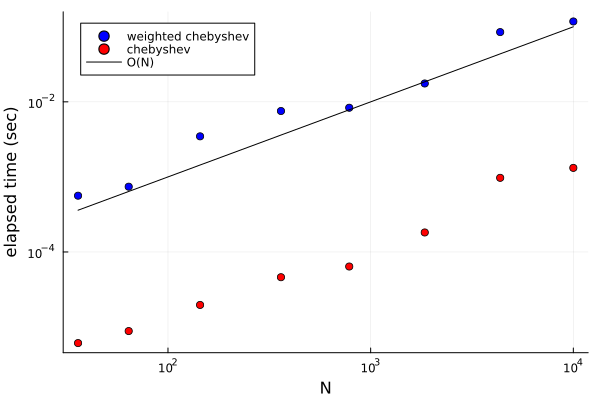

In [11]:
# plot of the timing (this takes about 1min40sec)
Nlist = ceil.(Int,sqrt.(10 .^range(log10(5^2),log10(100^2),8)))
scatter(Nlist.^2, [x[3] for x in weightedchebyshev_az1.(Nlist, 5, w, fun; timing=true)], yscale=:log10, xscale=:log10, label="weighted chebyshev", legend=:bottomleft, markercolor=:blue, xlabel="N", ylabel="elapsed time (sec)")
scatter!(Nlist.^2, [x[3] for x in chebyshev.(Nlist, fun; timing=true)], yscale=:log10, label="chebyshev", markercolor=:red)
plot!(Nlist.^2, Nlist.^2 .* 1e-5,label=:"O(N)",legend=:topleft, color=:black)

### Section 4.2.2 Approximation using oversampled Chebyshev grid with extra points

In [8]:
# approximate fun using N Chebsyhev polynomials and K weighted Chebyshev polynomials on an oversampled Chebyshev grid (M_N = 4N) with extra points close to the diagonal (M_K = 2K)
# using the AZ algorithm for enriched bases
function weightedchebyshev_az2(sqrtN, sqrtK, w, fun; timing=false, D=0..0.5)
    approxset = (ChebyshevT(sqrtN)→D)^2 ⊕ (w * ((ChebyshevT(sqrtK)→D)^2))
    basis = component(approxset,1)
    enriched = component(approxset,2)

    samples1 = (ChebyshevNodes(2sqrtN)→D) × (ChebyshevExtremae(2sqrtN)→D)
    zz = EquispacedGrid(sqrtK^2+2, D)[2:end-1]
    samples2 = ScatteredGrid(SVector.([zz; zz],[zz .+ 1e-3; zz .- 1e-3]))
    Z11op = BasisFunctions.leastsquares(basis, samples1)
    A11op = evaluation(basis, samples1)
    A21op = evaluation(basis, samples2)
    A12op = evaluation(enriched, samples1)
    A22op = evaluation(enriched, samples2)
    Z11 = FunctionMap{coefficienttype(approxset)}(t -> (Z11op*t)[:], sqrtN^2, length(samples1))
    A11 = FunctionMap{coefficienttype(approxset)}(t -> (A11op*t)[:], length(samples1), sqrtN^2)
    A21 = FunctionMap{coefficienttype(approxset)}(t -> (A21op*t)[:], length(samples2), sqrtN^2)
    A12 = FunctionMap{coefficienttype(approxset)}(t -> (A12op*t)[:], length(samples1), sqrtK^2)
    A22 = FunctionMap{coefficienttype(approxset)}(t -> (A22op*t)[:], length(samples2), sqrtK^2)
    rhs = [fun.(samples1[:]); fun.(samples2[:])]

    t = timing ? median(@benchmark(enrichedaz($A11, $A12, $A21, $A22, $Z11, $rhs))).time*1e-9 : 0.

    if (~timing)
        coeff = enrichedaz(A11, A12, A21, A22, Z11, [fun.(samples1[:]); fun.(samples2[:])]) 
        approx = Expansion(approxset, BlockArray(coeff, [sqrtN^2,sqrtK^2] ))
        xx = EquispacedGrid(150,D)[2:end] × (UnitPeriodicEquispacedGrid(150) → D)
        m = norm(fun.(xx) - approx.(xx), 2)/sqrt(length(xx[:])) # L^2 norm
    else
        m = 0.
        approx = Expansion(approxset,zeros(approxset))
    end

    m, approx, t
end

weightedchebyshev_az2 (generic function with 1 method)

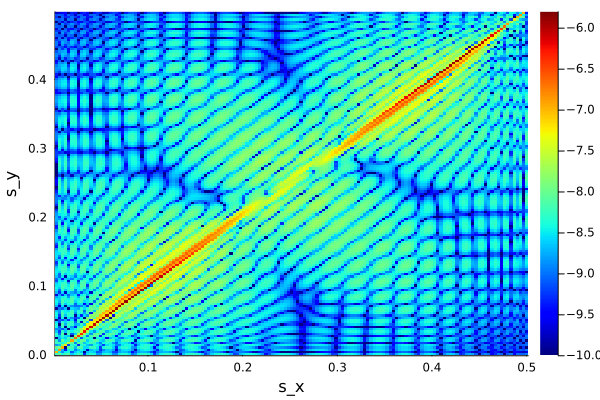

In [9]:
# error plot of the approximation using an oversampled Chebyshev grid
D = 0..0.5
xx = EquispacedGrid(150,D)[2:end]
yy = UnitPeriodicEquispacedGrid(150) → D
m, approx1, t = weightedchebyshev_az1.(30, 5, w, fun)
error1 = abs.(fun.(yy × xx) - approx1.(yy × xx))
heatmap(xx,yy,log10.(error1), xlabel="s_x", ylabel="s_y", clim=(-10,-5.8), c=:jet1)

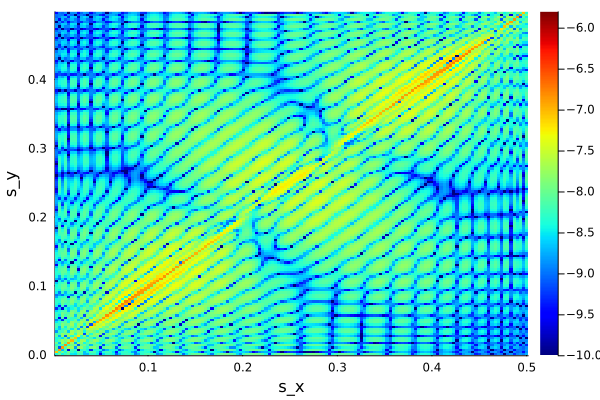

In [10]:
# error plot of the approximation using an oversampled Chebyshev grid with extra points close to the diagonal
m, approx2, t = weightedchebyshev_az2.(30, 5, w, fun)
error2 = abs.(fun.(yy × xx) - approx2.(yy × xx))
heatmap(xx,yy,log10.(error2), xlabel="s_x", ylabel="s_y", clim=(-10,-5.8), c=:jet1)

### Section 3.2 Singular value profile

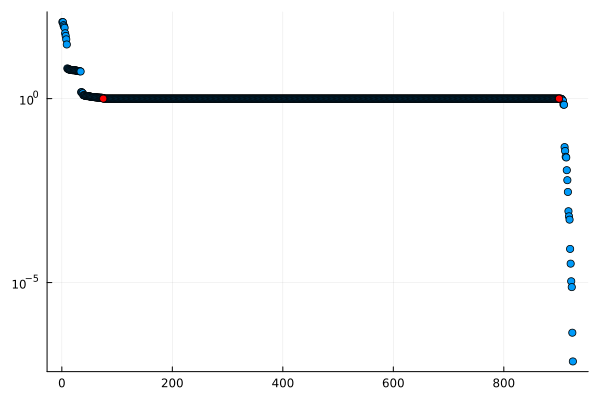

In [15]:
sqrtN = 30
sqrtK = 5
D = 0..0.5
w = (x1,x2) -> log(1/sqrt((gamma(x1)[1] - gamma(x2)[1])^2 + (gamma(x1)[2] - gamma(x2)[2])^2 + eps(0.)))                              
approxset = (BasisFunctions.normalize(ChebyshevT(sqrtN) → D))^2 ⊕ (w * (BasisFunctions.normalize(ChebyshevT(sqrtK)) → D)^2)
basis = component(approxset,1)
enriched = component(approxset,2)

# here I use ChebyshevNodes^2 (instead of ChebyshevNodes × ChebyshevExtremae as in the examples above) to obtain a subblock A11 with all singular values equal to 1
samples1 = (ChebyshevNodes(2sqrtN) → D)^2
zz = EquispacedGrid(sqrtK^2+2, D)[2:end-1]
samples2 = ScatteredGrid(SVector.([zz; zz],[zz .+ 1e-3; zz .- 1e-3]))

# I need to do proper scaling such that the singular values of A11 are equal to 1
A21 = evaluation_matrix(basis, samples2) .* pi ./(sqrt(2)sqrtK)
A12 = evaluation_matrix(enriched, samples1) .* pi ./(2sqrtN)
A22 = evaluation_matrix(enriched, samples2) .* pi ./(sqrt(2)sqrtK)
A11 = evaluation_matrix(basis,samples1) .* pi ./ (2sqrtN)

# singular value profile of A
vals = svdvals([A11 A12; A21 A22])
scatter(vals, yscale=:log10, label="")
scatter!([75,],[1,],markercolour=:red, label="")
scatter!([N^2,],[1,],markercolour=:red, label="")

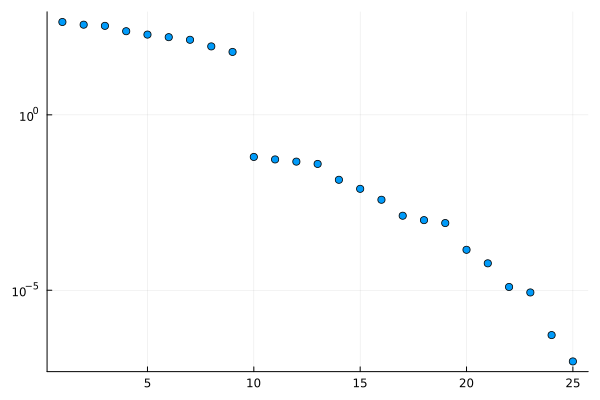

In [16]:
# singular value profile of A-AZA
Z11 = adjoint(A11) # left inverse of A11
vals = svdvals([A12 - A11*Z11*A12; A22 - A21*Z11*A12])
scatter(vals, yscale=:log10, label="")